# Depth estimation network using DenseNet169  

Initialization of the used libraries

In [ ]:
!pip install torchmetrics

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# %cd ./content/drive/MyDrive/
# %cd drive/MyDrive/
# %cd drive/MyDrive/CV2/
# only external
# %cd ../
models_dir = "./model_dir"

Mounted at /content/drive
/content/drive/MyDrive


In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.models import densenet121
from torchvision.transforms import ToTensor
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics.image import StructuralSimilarityIndexMeasure
from torch.optim import Adam
import matplotlib.pyplot as plt
import random
import pandas as pd
import os
from PIL import Image
import numpy as np
import time

random.seed(19)

# Augmentation policy used for the training of the dataset

In [ ]:
class BasicPolicy(object):
  def __init__(self, mirror_ratio=0, flip_ratio=0, color_change_ratio=0, is_full_set_colors=False, add_noise_peak=0.0, erase_ratio=-1.0):
    # Random color channel order
    from itertools import product, permutations
    self.indices = list(product([0, 1, 2], repeat = 3)) if is_full_set_colors else list(permutations(range(3), 3))
    self.indices.insert(0, [0, 1, 2])# R, G, B
    self.add_noise_peak = add_noise_peak

    # Mirror and flip
    self.color_change_ratio = color_change_ratio
    self.mirror_ratio = mirror_ratio
    self.flip_ratio = flip_ratio

    # erase
    self.erase_ratio = erase_ratio

  def __call__(self, img, depth):
    # 0) Add poisson noise (e.g. choose peak value 20)
    # https://stackoverflow.com/questions/19289470/adding-poisson-noise-to-an-image
    if self.add_noise_peak > 0:
          PEAK = self.add_noise_peak
          img = np.random.poisson(np.clip(img, 0, 1) * PEAK) / PEAK

    # Color change
    policy_idx = random.randint(0,len(self.indices)-1)
    if random.uniform(0, 1) >= self.color_change_ratio:
      policy_idx = 0

    img = img[...,list(self.indices[policy_idx])]

    # Mirror image
    if random.uniform(0,1) <= self.mirror_ratio:
      img = img[...,::-1,:].copy()
      depth = depth[...,::-1].copy()

    # Flip image vertically
    if random.uniform(0, 1) < self.flip_ratio:
      img = img[::-1,:,:].copy()
      depth = depth[::-1,:].copy()

    # 4) Erase random box
    if random.uniform(0, 1) < self.erase_ratio:
      img = self.eraser(img)

    return img, depth

  def __repr__(self):
    return "Basic Policy"

  def eraser(self, input_img, p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=True):
    img_h, img_w, img_c = input_img.shape
    p_1 = np.random.rand()

    if p_1 > p:
      return input_img

    while True:
      s = np.random.uniform(s_l, s_h) * img_h * img_w
      r = np.random.uniform(r_1, r_2)
      w = int(np.sqrt(s / r))
      h = int(np.sqrt(s * r))
      left = np.random.randint(0, img_w)
      top = np.random.randint(0, img_h)

      if left + w <= img_w and top + h <= img_h:
        break

    if pixel_level:
        c = np.random.uniform(v_l, v_h, (h, w, img_c))
    else:
        c = np.random.uniform(v_l, v_h)

    input_img[top:top + h, left:left + w, :] = c

    return input_img


# Dataset loader and necessary preprocessing steps

In [ ]:
def nyu_resize(img, resolution=480, padding=6):
    from skimage.transform import resize
    return resize(img, (resolution, int(resolution*4/3)), preserve_range=True, mode='reflect', anti_aliasing=True)

def DepthNorm(x, maxDepth):
    return maxDepth / x

class NYUv2_Dataset_Augmented(Dataset):
    def __init__(self, annotations_file, fraction = 1, seed = 42, transform=None, target_transform=None, is_flip=False, is_addnoise=False, is_erase=False):
        self.img_labels = pd.read_csv(annotations_file).sample(frac=fraction,
                                                          random_state=seed)
        self.transform = transform
        self.target_transform = target_transform
        self.policy = BasicPolicy( color_change_ratio=0.50, mirror_ratio=0.50, flip_ratio=0.0 if not is_flip else 0.2,
                                  add_noise_peak=0 if not is_addnoise else 20, erase_ratio=-1.0 if not is_erase else 0.5)

        self.maxDepth = 1000.0


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx, is_apply_policy=True):
        img_path = self.img_labels.iloc[idx, 0]
        x = np.clip(np.asarray(Image.open(img_path).convert('RGB'))/255,0,1)
        x = nyu_resize(x, 480)
        label_path = self.img_labels.iloc[idx, 1]
        y = np.clip(np.asarray(Image.open(label_path))/255*self.maxDepth,0,self.maxDepth)
        y = DepthNorm(y, maxDepth=self.maxDepth)
        y = nyu_resize(y, 240)

        if is_apply_policy: x, y = self.policy(x, y)

        if self.transform:
            x = self.transform(x)

        if self.target_transform:
            y = self.target_transform(y)

        return x.float(), y.float()


class NYUv2_Dataset(Dataset):
    def __init__(self, annotations_file, fraction = 1, seed = 42, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file).sample(frac=fraction,
                                                          random_state=seed)
        self.transform = transform
        self.target_transform = target_transform

        self.maxDepth = 1000.0


    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx, is_apply_policy=True):
        img_path = self.img_labels.iloc[idx, 0]
        x = np.clip(np.asarray(Image.open(img_path).convert('RGB'))/255,0,1)
        x = nyu_resize(x, 480)
        label_path = self.img_labels.iloc[idx, 1]
        y = np.asarray(Image.open(label_path), dtype=np.float32).reshape(480,640,1).copy().astype(float) / 10.0
        y = DepthNorm(y, maxDepth=self.maxDepth)
        y = nyu_resize(y, 240)

        if self.transform:
            x = self.transform(x)

        if self.target_transform:
            y = self.target_transform(y)

        return x.float(), y.float()

In [ ]:
trainset = NYUv2_Dataset_Augmented('data/nyu2_train.csv', fraction=0.04, seed=19,
                                   transform=ToTensor(), target_transform=ToTensor())

# testset = NYUv2_Dataset_Augmented('data/nyu2_test.csv', fraction=1, seed=19, transform=ToTensor(),
#                        target_transform=ToTensor())


In [ ]:
print(f'Items in train dataset: {len(trainset)}')
print(f"Items in test dataset: {len(testset)}")

Items in train dataset: 2027
Items in test dataset: 653


torch.Size([3, 480, 640])


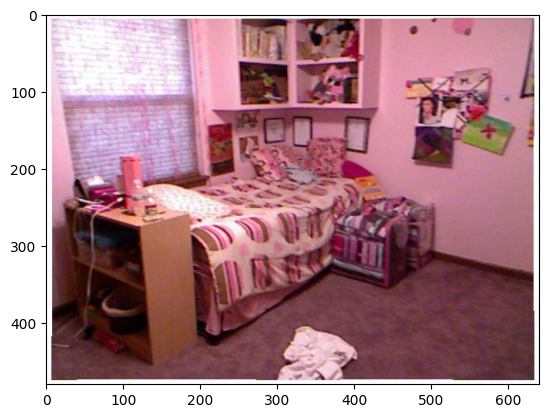

torch.Size([3, 480, 640])


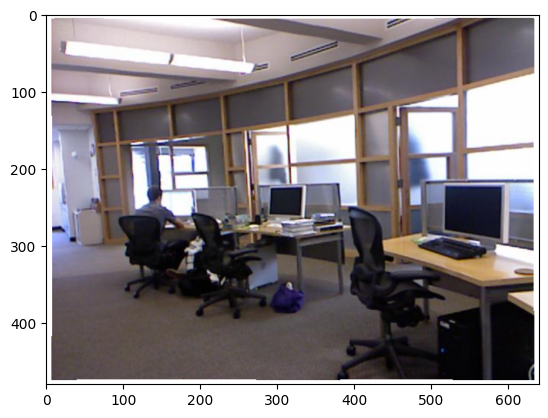

In [ ]:
for image, label in trainset:
  imgtrain = image
  lbltrain = label
  break

print(imgtrain.shape)
plt.figure('1')
plt.imshow(imgtrain.permute(1,2,0))
plt.show()
"""
for image, label in testset:
  imgtest = image
  lbltest = label
  break

print(imgtest.shape)
plt.figure("2")
plt.imshow(imgtest.permute(1,2,0))
plt.show()
"""

torch.Size([1, 240, 320])


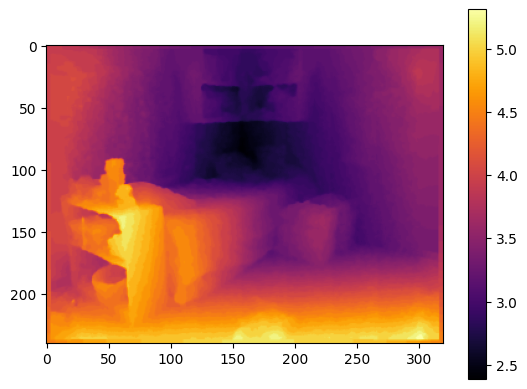

torch.Size([1, 240, 320])


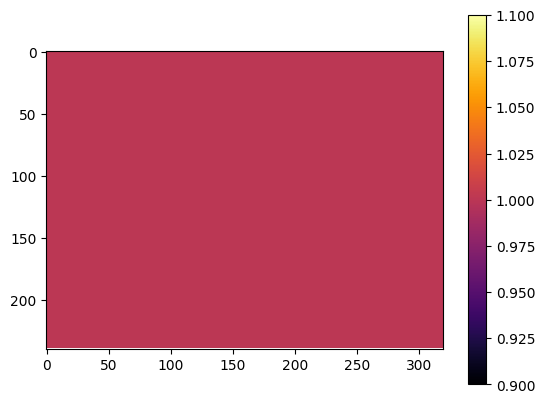

In [ ]:
print(lbltrain.shape)
plt.imshow(lbltrain.permute(1,2,0), cmap='inferno'), plt.colorbar()
plt.show()
"""
print(lbltest.shape)
plt.imshow(lbltest.permute(1,2,0), cmap='inferno'), plt.colorbar()
plt.show()
"""

In [ ]:
print(img.min(), img.max())

tensor(0.) tensor(1.)


In [ ]:
print(lbl.min(), lbl.max())

tensor(2.3867) tensor(5.3125)


# Hyperparameters definition and dataset split
75% - training / 25%- validation

In [ ]:
# defining hyperparameters
INIT_LR = 0.0001
BATCH_SIZE = 6
EPOCHS = 100

# defining train-validation splits
TRAIN_SPLIT = 0.75
VAL_SPLIT = 0.25

# selecting available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"[INFO] device selected for training...{device}")

[INFO] device selected for training...cuda


In [ ]:
print("[INFO] generating the train/val split...")
numTrainSamples = int(len(trainset)*TRAIN_SPLIT)
numValSamples = int(len(trainset)-numTrainSamples)

print(f"[INFO] the split will be...train data: {numTrainSamples} / val data: {numValSamples}")
(trainData, valData) = random_split(trainset, [numTrainSamples, numValSamples], generator=torch.Generator().manual_seed(19))

[INFO] generating the train/val split...
[INFO] the split will be...train data: 1520 / val data: 507


In [ ]:
# initialize the train, validation dataloaders
trainDataLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valDataLoader = DataLoader(valData, batch_size=BATCH_SIZE)
# testDataLoader = DataLoader(testset, batch_size=BATCH_SIZE)

# calculate the number of steps per epoch for train and validation sets
trainSteps = len(trainDataLoader.dataset) // BATCH_SIZE
valSteps = len(valDataLoader.dataset) // BATCH_SIZE
# testSteps = len(testDataLoader.dataset) // BATCH_SIZE

print(f"[INFO] Train iterations:{trainSteps} / Validation Iterations:{valSteps}")
# print(f"[INFO] Train iterations:{trainSteps} / Validation Iterations:{valSteps} / Test Iterations:{testSteps}")

[INFO] Train iterations:253 / Validation Iterations:84 / Test Iterations:108


# Model Implementation
After the suggested implementation in the paper

https://arxiv.org/pdf/1812.11941.pdf

In [ ]:
# Defining model's components
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.densenet = densenet121(weights='IMAGENET1K_V1')

    def forward(self, x):
        features = []
        for name, module in self.densenet.features.named_children():
            x = module(x)
            if name in {'relu0', 'pool0', 'transition1', 'transition2', 'norm5'}:
                features.append(x)
        return features

class DecoderBlock(nn.Module):
  def __init__(self, in_channels, middle_channels, out_channels):
    super(DecoderBlock, self).__init__()
    self.upsample = nn.Upsample(scale_factor=(2, 2), mode='bilinear', align_corners=True)
    self.conv1 = nn.Conv2d(in_channels + middle_channels, out_channels, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    self.leakyReLU = nn.LeakyReLU(negative_slope=0.2, inplace=True)

  def forward(self, x, skip_features):
    up = self.upsample(x)
    up = torch.cat([up, skip_features], dim=1) # Concatenate along the channel dimension
    up = self.leakyReLU(self.conv1(up))
    up = self.leakyReLU(self.conv2(up))

    return up


class Decoder(nn.Module):
  def __init__(self, num_classes=1, decode_filters=1024):
    super(Decoder,self).__init__()
    self.convA = nn.Conv2d(decode_filters, decode_filters, kernel_size=1)
    self.upblock1 = DecoderBlock(decode_filters, 256, int(decode_filters//2))
    self.upblock2 = DecoderBlock(int(decode_filters/2), 128, int(decode_filters/4))
    self.upblock3 = DecoderBlock(int(decode_filters/4), 64, int(decode_filters/8))
    self.upblock4 = DecoderBlock(int(decode_filters/8), 64, int(decode_filters/16))
    self.convB = nn.Conv2d(int(decode_filters/16), 1, kernel_size=3, padding=1)

  def forward(self, features):
    x = self.convA(features[-1])
    x = self.upblock1(x, features[-2])
    x = self.upblock2(x, features[-3])
    x = self.upblock3(x, features[-4])
    x = self.upblock4(x, features[-5])
    x = self.convB(x)

    return x


class DenseNetUNet(nn.Module):
  def __init__(self, n_classes=1, decoder_filters=1024):
    super(DenseNetUNet, self).__init__()
    self.Encoder = Encoder()
    self.Decoder = Decoder(n_classes, decoder_filters)

  def forward(self, x):
    features = self.Encoder(x)
    x = self.Decoder(features)

    return x


# Some tests on the model

In [ ]:
# Function to be called by the hook
def print_output_shape(module, input, output):
    print("Output shape:", output.shape)

# Load a pre-trained DenseNet121 model
from torchvision.models import densenet121
model = densenet121(pretrained=True)
encoder_features = model.features

model169 = densenet169(pretrained=True)
encoder_features169 = model169.features

# Register a forward hook for each layer in encoder_features
for layer in encoder_features:
    if hasattr(layer, "register_forward_hook"):
        # print(layer)
        layer.register_forward_hook(print_output_shape)

for layer in encoder_features169:
    if hasattr(layer, "register_forward_hook"):
        # print(layer)
        layer.register_forward_hook(print_output_shape)

# Create a dummy input and perform a forward pass to see the output shape
dummy_input = torch.randn(1, 3, 480, 640)  # Example input tensor

# Forward the dummy input through the encoder_features to print the shape of each layer's output
print(len(encoder_features))
encoder_features(dummy_input)

print(len(encoder_features169))
encoder_features169(dummy_input)


12
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 120, 160])
Output shape: torch.Size([1, 256, 120, 160])
Output shape: torch.Size([1, 128, 60, 80])
Output shape: torch.Size([1, 512, 60, 80])
Output shape: torch.Size([1, 256, 30, 40])
Output shape: torch.Size([1, 1024, 30, 40])
Output shape: torch.Size([1, 512, 15, 20])
Output shape: torch.Size([1, 1024, 15, 20])
Output shape: torch.Size([1, 1024, 15, 20])
12
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 240, 320])
Output shape: torch.Size([1, 64, 120, 160])
Output shape: torch.Size([1, 256, 120, 160])
Output shape: torch.Size([1, 128, 60, 80])
Output shape: torch.Size([1, 512, 60, 80])
Output shape: torch.Size([1, 256, 30, 40])
Output shape: torch.Size([1, 1280, 30, 40])
Output shape: torch.Size([1, 640, 15, 20])
Output shape: torch.Size([1, 166

tensor([[[[ 2.8232e-03,  8.8912e-04,  1.0010e-03,  ...,  1.9950e-03,
           -8.8221e-04, -9.5301e-03],
          [ 1.1208e-03, -3.2722e-04, -2.2339e-03,  ...,  3.1306e-03,
            4.4384e-04, -5.3538e-04],
          [-4.1242e-04, -1.1463e-04, -1.0457e-03,  ...,  1.4975e-03,
           -1.4149e-03,  1.4613e-03],
          ...,
          [ 2.9175e-03,  1.0951e-03,  9.1642e-04,  ...,  1.1689e-03,
            2.0005e-03,  3.7635e-04],
          [ 2.4077e-03,  3.3331e-03,  3.8398e-04,  ...,  2.6242e-03,
            5.5255e-04, -2.6720e-03],
          [-7.2930e-04,  1.8065e-03,  4.6683e-03,  ...,  1.0896e-04,
            4.5987e-04, -4.6345e-03]],

         [[-2.9753e-03,  1.7914e-03, -1.2795e-03,  ..., -2.4942e-04,
           -1.6022e-03, -1.9765e-03],
          [ 2.8861e-04,  2.4319e-03, -9.6719e-04,  ...,  1.1736e-03,
            1.7023e-03, -3.5548e-03],
          [-4.2818e-04,  2.4137e-04, -1.5638e-03,  ..., -9.8233e-04,
            2.1784e-03,  7.1354e-04],
          ...,
     

In [ ]:
model = DenseNetUNet().to(device)
for img, label in trainDataLoader:
  img = img.to(device)
  label = label.to(device)
  out = model(img)
  print(out.shape)
  break
# Dureaza cam mult sa incarce datele si sa itereze prin tot modelul (cam 20 de secunde)


# Early Stop functionality

In [ ]:
# defining Early Stopping class

class EarlyStopping():
  def __init__(self, patience = 1, min_delta = 0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.min_validation_loss = np.inf
    self.best_epoch = 0
    self.best_train = None
    self.best_val = None

  def earlyStop(self, epoch, trainLoss, valLoss, model):
    if valLoss <= (self.min_validation_loss + self.min_delta):
      print("[INFO] In EPOCH {} the loss value improved from {:.5f} to {:.5f}".format(epoch, self.min_validation_loss, valLoss))
      self.setMinValLoss(valLoss)
      self.setCounter(0)
      self.setBestEpoch(epoch)
      torch.save(model.state_dict(), f"{models_dir}/DenseDepthNet121_state_dict.pt")
      self.setBestLosses(trainLoss, valLoss)

    elif valLoss > (self.min_validation_loss + self.min_delta):
      self.setCounter(self.counter + 1)
      print("[INFO] In EPOCH {} the loss value did not improve from {:.5f}. This is the {} EPOCH in a row.".format(epoch, self.min_validation_loss, self.counter))
      if self.counter >= self.patience:
        return True
    return False

  def setCounter(self, counter_state):
    self.counter = counter_state

  def setMinValLoss(self, ValLoss):
    self.min_validation_loss = ValLoss

  def setBestLosses(self, TrainLoss, ValLoss):
    self.best_train = TrainLoss
    self.best_val = ValLoss

  def setBestEpoch(self, bestEpoch):
    self.best_epoch = bestEpoch

  def getBestTrainLosses(self):
    return self.best_train

  def getBestValLosses(self):
    return self.best_val

  def getBestEpoch(self):
    return self.best_epoch

  def saveLossesLocally(self):
    np.save(f'{models_dir}/losses_train_121.npy', np.array(self.best_train))
    np.save(f'{models_dir}/losses_val_121.npy', np.array(self.best_val))

  def loadLossesLocally(self):
    self.best_train = np.load(f'{models_dir}/losses_train_121.npy')
    self.best_val = np.load(f'{models_dir}/losses_val_121.npy')
    self.min_validation_loss = self.best_val


# Loss Function

In [ ]:
# implementation of the loss function (questionable I might say)
def compute_gradients(image):
    # Define the Sobel operator for edge detection
    sobel_x = torch.tensor([[-1., 0., 1.], [-2., 0., 2.], [-1., 0., 1.]], dtype=torch.float32).reshape(1, 1, 3, 3)
    sobel_y = torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]], dtype=torch.float32).reshape(1, 1, 3, 3)

    # Add extra dimensions to match the image tensor shape
    sobel_x = sobel_x.to(image.device)
    sobel_y = sobel_y.to(image.device)

    # Compute the gradients
    grad_x = nn.functional.conv2d(image, sobel_x, padding=1)
    grad_y = nn.functional.conv2d(image, sobel_y, padding=1)

    return grad_x, grad_y


def depth_loss_function(y_true, y_pred, tetha = 0.1, maxDepthVal=1000.0/10.0):

  # point-wise depth
  l_depth = torch.mean(torch.abs(y_pred - y_true), dim=(1, 2, 3))

  # Edges
  dy_true, dx_true = compute_gradients(y_true)
  dy_pred, dx_pred = compute_gradients(y_pred)
  l_edges = torch.mean(torch.abs(dy_pred - dy_true) + torch.abs(dx_pred - dx_true), dim=(1, 2, 3))

  # Structural similarity Index (SSIM)
  ssim_module = StructuralSimilarityIndexMeasure(data_range=maxDepthVal).to(y_true.device)
  l_ssim = torch.clamp((1 - ssim_module(y_true, y_pred)) * 0.5, 0, 1)

  # weights
  w1 = 1.0
  w2 = 1.0
  w3 = tetha

  return (w1 * l_ssim) + (w2 * torch.mean(l_edges)) + (w3 * torch.mean(l_depth))


# Training loop

In [ ]:
# loading previous training state
# previous_state = torch.load(f"{models_dir}/train_state_dict_121.pt")
# previous_model = torch.load(f"{models_dir}/DenseDepthNet121_state_dict.pt")

# initializing model
print("[INFO] Encoder-Decoder network is being initialized...")
model = DenseNetUNet().to(device)
# model.load_state_dict(previous_model)

# model.load_state_dict(previous_state['model_state_dict'])

# initializing the optimizer, loss function and accuracy measurement
optimizer = Adam(model.parameters(), lr=INIT_LR)
# optimizer.load_state_dict(previous_state['optimizer_state_dict'])

# loading LR Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
# scheduler.load_state_dict(previous_state['scheduler_state_dict'])

# initialize a dictionary to store training and evaluation history
# will be used for plotting the loss curve

H = {
    "train_loss":[],
    "val_loss":[],
    "time":[]
}

# H = previous_state['train_loss_history']
# last_epoch = previous_state['epoch']

# measure how long training is going to take
print("[INFO] training the network...")
startTime = time.time()
H["time"].append(startTime)

[INFO] Encoder-Decoder network is being initialized...


In [ ]:
# loop over training epochs

early_stopper = EarlyStopping(patience = 9)
# early_stopper.min_validation_loss = H["val_loss"][-6]
# early_stopper.setCounter(5)

accumulation_steps = 4

# for e in range(last_epoch+1, EPOCHS):
for e in range(EPOCHS):
  # set the model to training mode
  model.train()
  optimizer.zero_grad()

  train_loss = 0
  val_loss = 0

  for step, (image, gt_map) in enumerate(trainDataLoader):
    # sending the input to the device
    image = image.to(device)
    gt_map = gt_map.to(device)

    # perform a forward pass and calculate training loss
    pred_map = model(image)
    loss = depth_loss_function(gt_map, pred_map) / accumulation_steps  # for normalization
    loss.backward()

    # we will apply weights optimization every 3 batches for more stable gradients
    # 4 batches x 8 images/batch = 24 data passes
    if step+1 != 1:
      if (accumulation_steps % (step+1) == 0) or (trainSteps % (step+1) != 0 and trainSteps == (step+1)):
        optimizer.step()
        optimizer.zero_grad()
        # print(f"Train loss at {step+1} is: {(train_loss+loss.cpu().detach().numpy())/step+1}")

    # add the loss to the total training so far
    train_loss += loss.cpu().detach().numpy()

  # switch off autograd for evaluation
  with torch.no_grad():
    # set the model in evaluation mode
    model.eval()

    # for loop over the validation set
    for (image, gt_map) in valDataLoader:
      # sending input to device
      image = image.to(device)
      gt_map = gt_map.to(device)

      # make prediction and calculate validation loss
      pred_map = model(image)

      # calculate loss
      val_loss += depth_loss_function(gt_map, pred_map).cpu().detach().numpy()


  # calculate the average training and validation loss
  H['train_loss'].append(train_loss / trainSteps)
  H['val_loss'].append(val_loss/ valSteps)
  H['time'].append(time.time())

  scheduler.step(H['val_loss'][e])
  # saving current state dicts of the epoch and loss history - checkpoint
  torch.save({
            'epoch': e,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict':scheduler.state_dict(),
            'train_loss_history': H
            }, f"{models_dir}/train_state_dict_121.pt")

  # print the model training and validation information
  print("[INFO] EPOCH: {}/{} ...".format(e+1, EPOCHS))
  print("Train loss: {:.5f}".format(H['train_loss'][e]))
  print("Validation loss: {:.5f}".format(H['val_loss'][e]))

  # checking if resulting loss in evaluation is the best
  if early_stopper.earlyStop((e+1), H['train_loss'][e], H['val_loss'][e], model):
    # if it is not better - stopping train process
    print("[INFO] Early Stopping the train process. The patience has been exceeded!")
    print("===========================================================================================")
    break

  print("===========================================================================================")

# finish measuring how long training took
endTime = time.time()
H['time'].append(endTime)
print("[INFO] Total time taken to train the model: {:.2f}s".format(endTime-H['time'][0]))
print("[INFO] The best loss value was found in EPOCH {} where the performance was {:.5f}. Model's parameters saved!".format(early_stopper.getBestEpoch(), early_stopper.getBestValLosses()[0]))
early_stopper.saveLossesLocally()

[INFO] EPOCH: 66/100 ...
Train loss: 0.24989
Validation loss: 0.74868
[INFO] In EPOCH 66 the loss value did not improve from 0.73262. This is the 6 EPOCH in a row.
[INFO] EPOCH: 67/100 ...
Train loss: 0.24801
Validation loss: 0.74249
[INFO] In EPOCH 67 the loss value did not improve from 0.73262. This is the 7 EPOCH in a row.
[INFO] EPOCH: 68/100 ...
Train loss: 0.24533
Validation loss: 0.73845
[INFO] In EPOCH 68 the loss value did not improve from 0.73262. This is the 8 EPOCH in a row.
[INFO] EPOCH: 69/100 ...
Train loss: 0.24540
Validation loss: 0.73567
[INFO] In EPOCH 69 the loss value did not improve from 0.73262. This is the 9 EPOCH in a row.
[INFO] Early Stopping the train process. The patience has been exceeded!
[INFO] Total time taken to train the model: 314690.62s


TypeError: 'NoneType' object is not subscriptable

# Testing the model


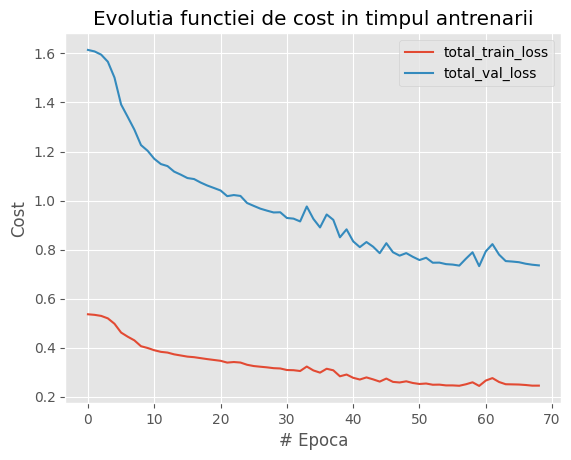

In [ ]:
# plot the training and val losses
plt.style.use("ggplot")

# Plotting loss on train and evaluation
plt.figure("total_loss").clear()
plt.plot(H["train_loss"], label="total_train_loss", linestyle="solid")
plt.plot(H["val_loss"], label="total_val_loss", linestyle="solid")
plt.title("Evolutia functiei de cost in timpul antrenarii")
plt.xlabel("# Epoca")
plt.ylabel("Cost")
plt.legend(loc="upper right")
plt.savefig(f"{models_dir}/train_val_graph.png")

In [ ]:
# switching off autograd for eval
with torch.no_grad():
  # set the model in eval mode
  model.eval()
  total_loss = 0
  for images, gt_maps in testDataLoader:
    images = images.to(device)
    gt_maps = gt_maps.to(device)

    pred_maps= model(images)
    total_loss += depth_loss_function(gt_maps, pred_maps)

  print(f"Total loss on test: {total_loss/testSteps}")

# INCONCLUZIV! SETUL DE DATE CONTINE PE TEST IMAGINI UNLABELLED (CU MASTI PLINE DE 0)

Total loss on test: 0.9232441186904907


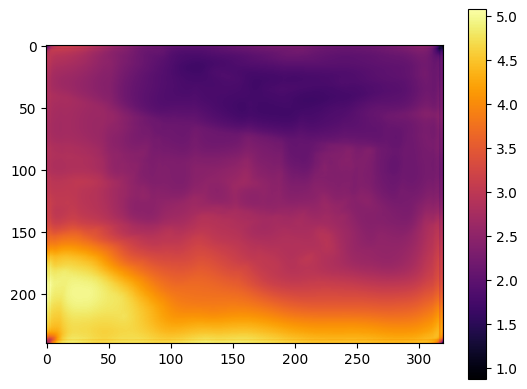

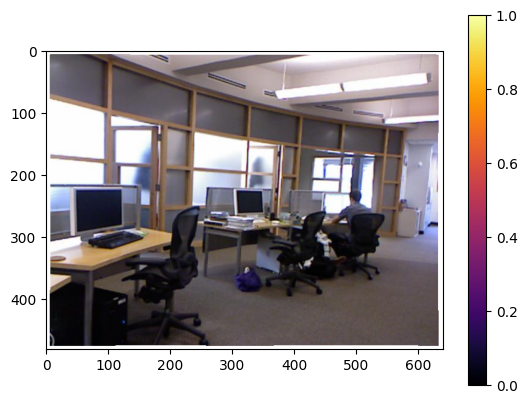

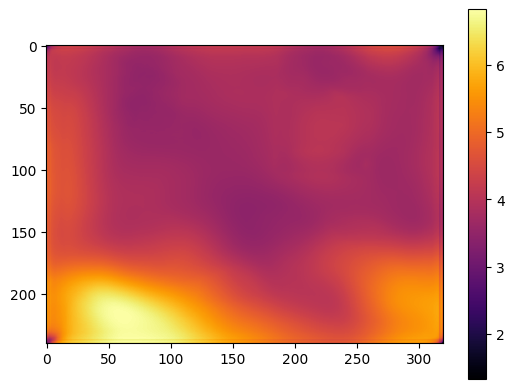

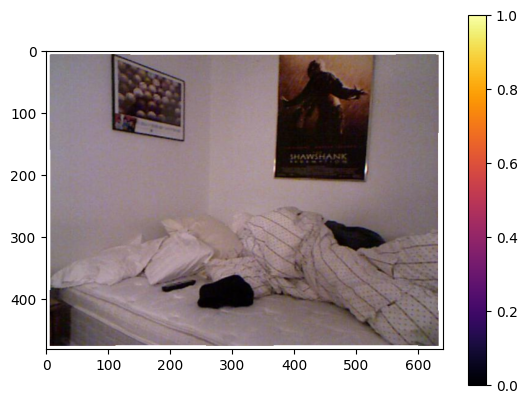

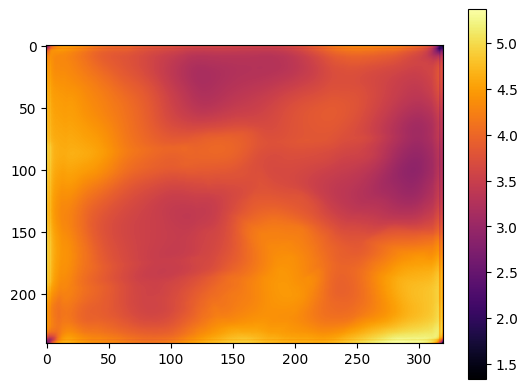

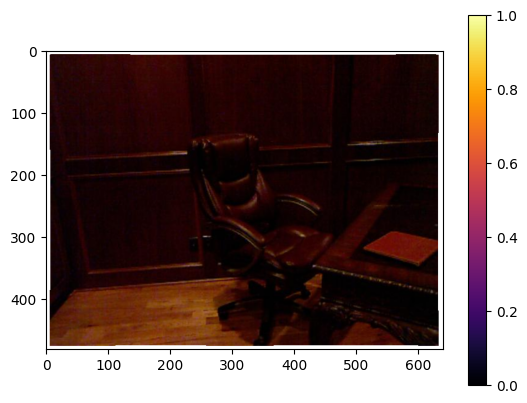

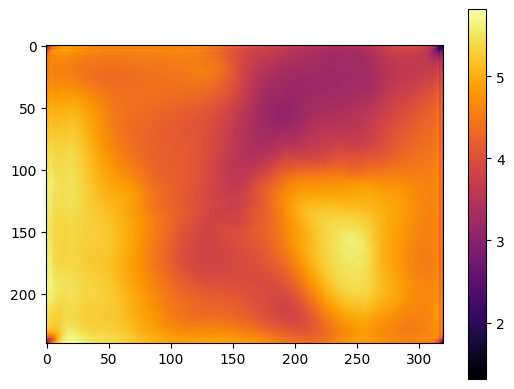

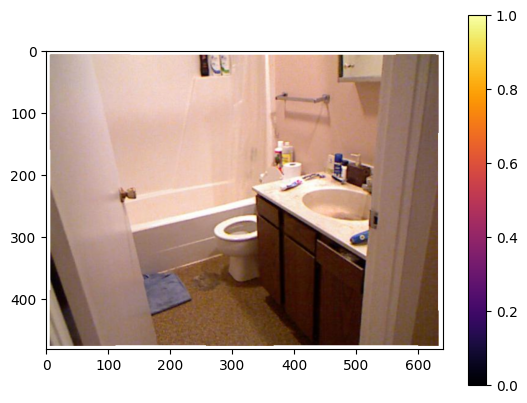

In [ ]:
for images, gt_maps in testDataLoader:
  images = images.to(device)
  gt_maps = gt_maps.to(device)

  pred_maps = model(images)

  plt.figure("pred_map")
  plt.imshow(pred_maps[0].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(images[0].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[1].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(images[1].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[2].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(images[2].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[3].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(images[3].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  break



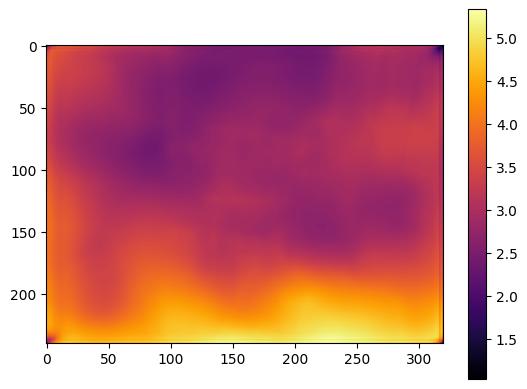

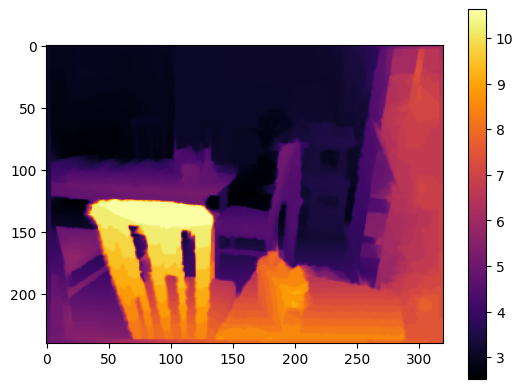

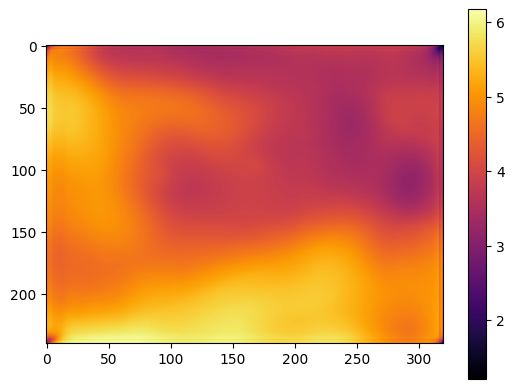

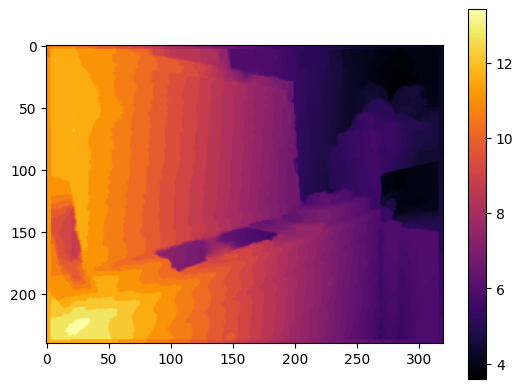

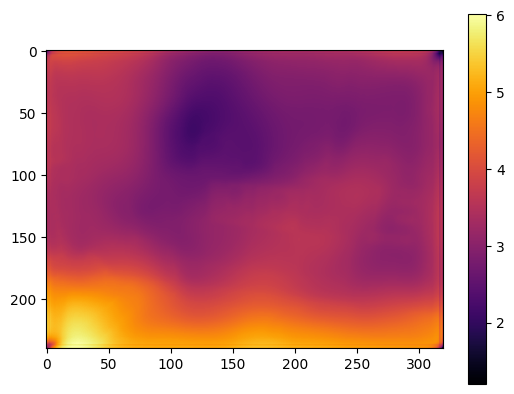

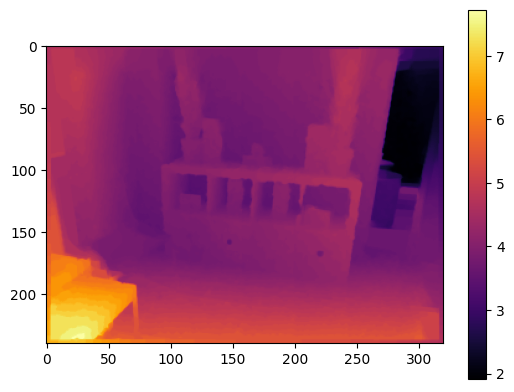

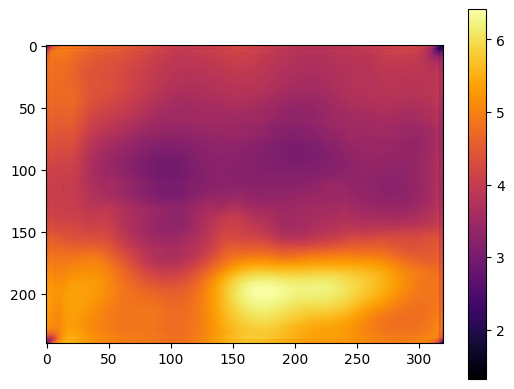

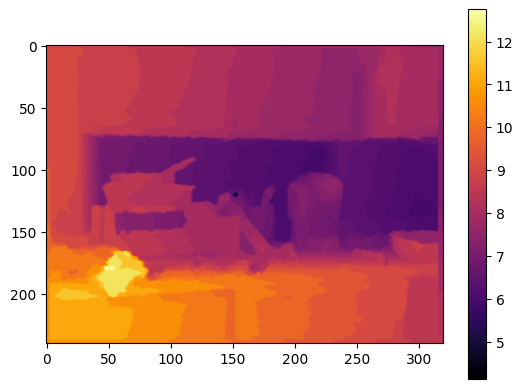

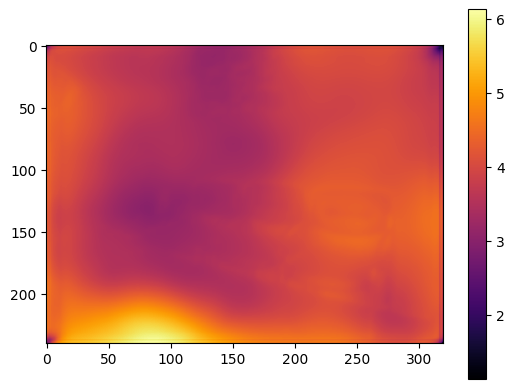

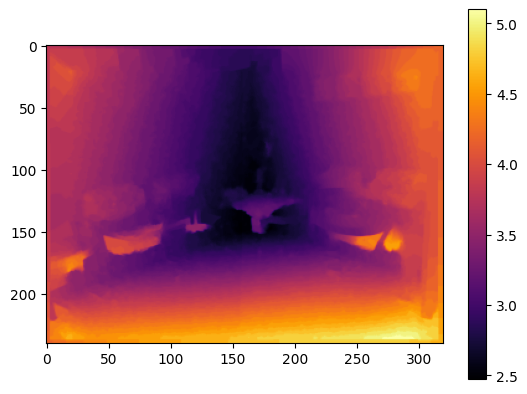

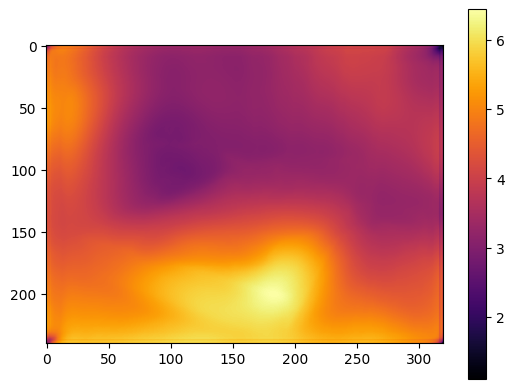

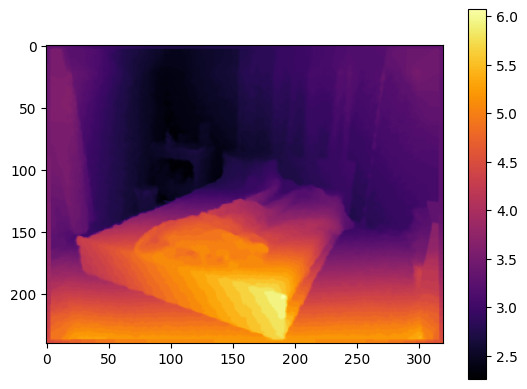

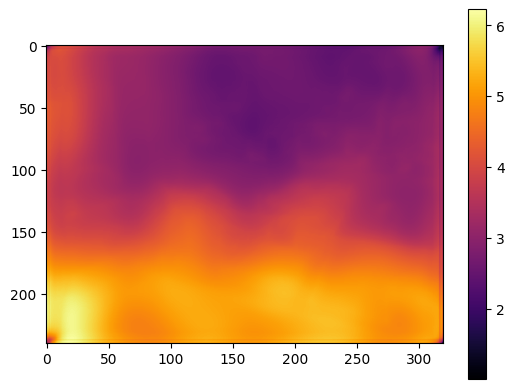

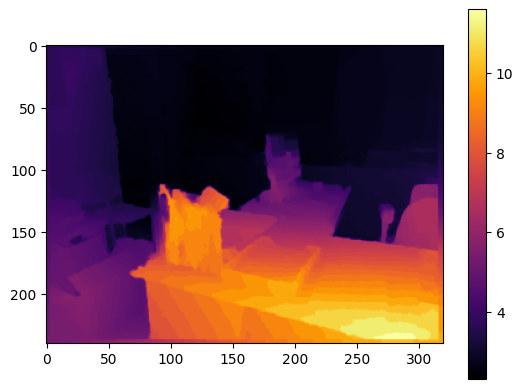

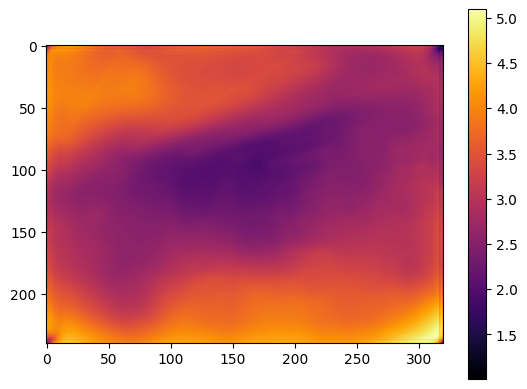

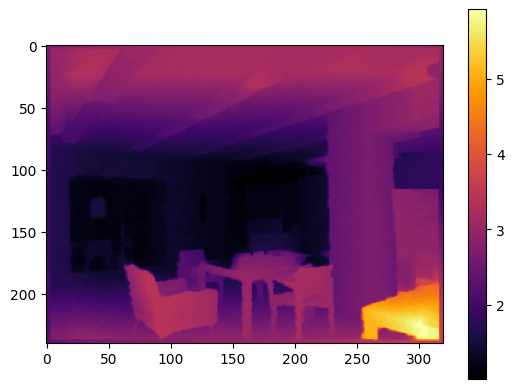

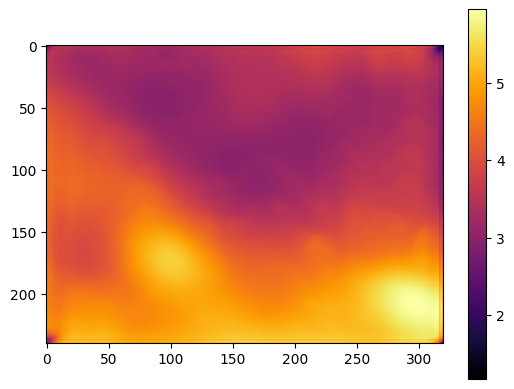

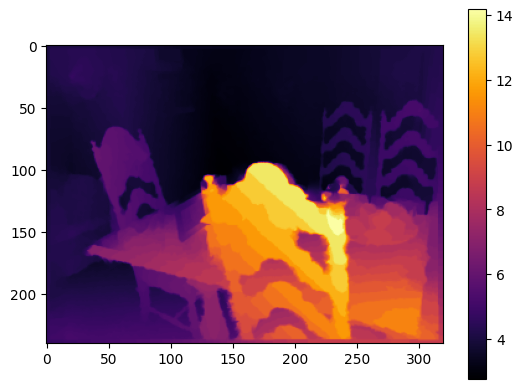

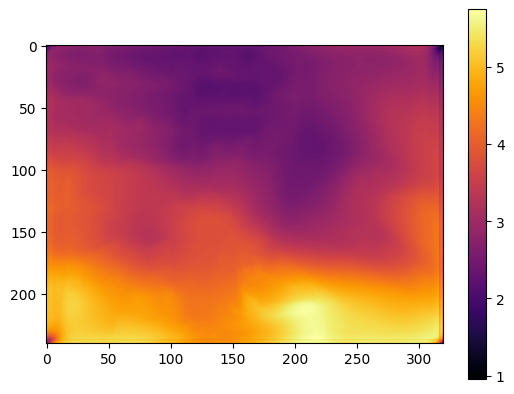

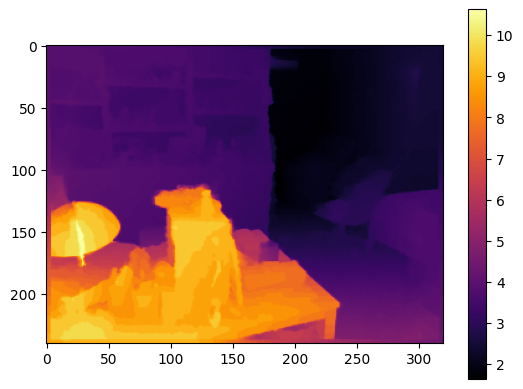

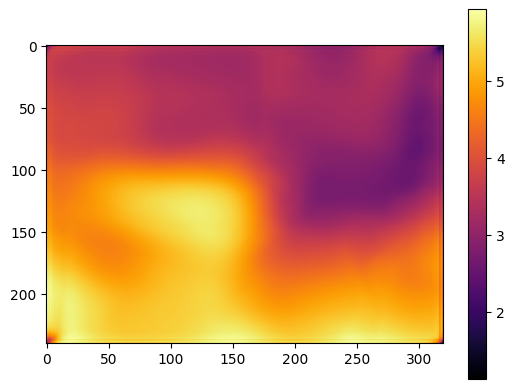

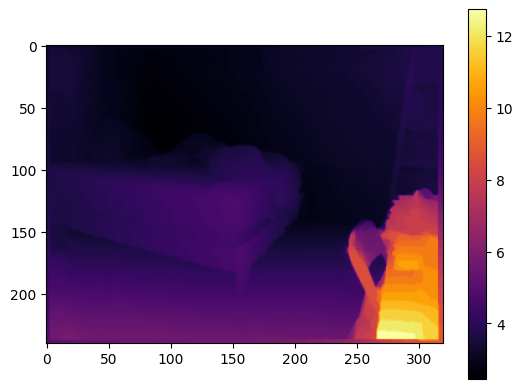

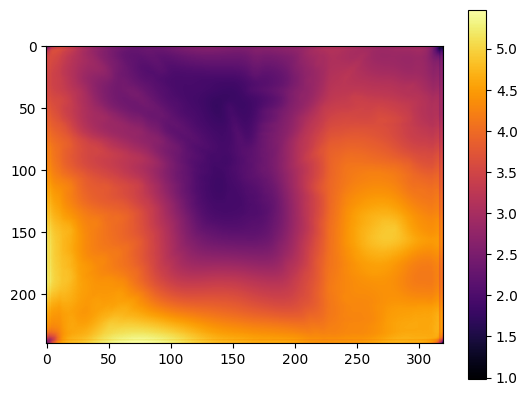

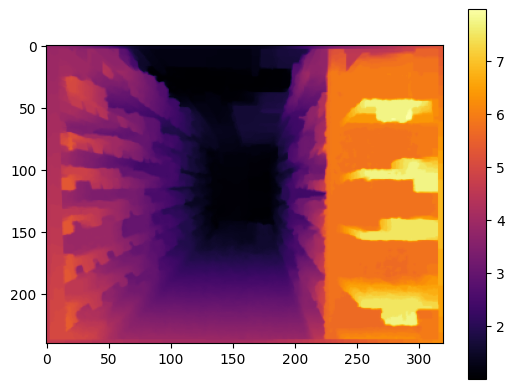

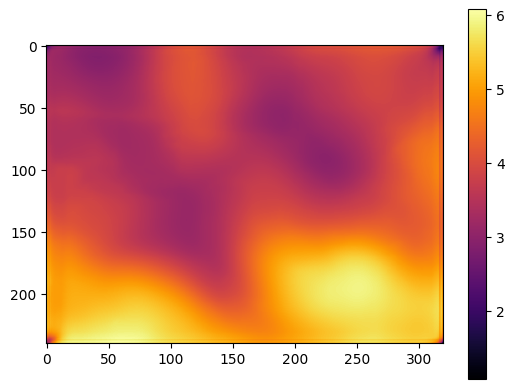

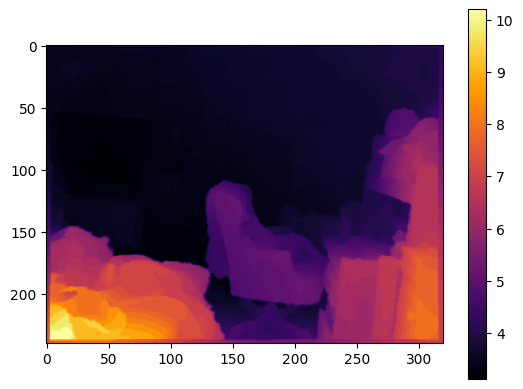

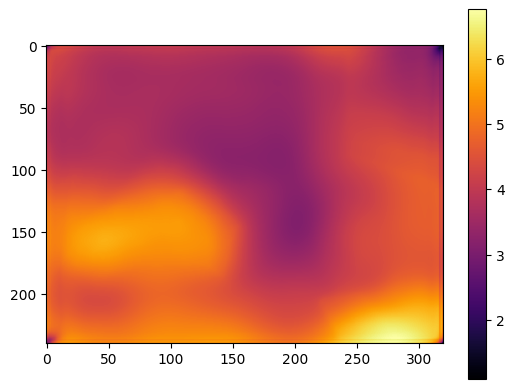

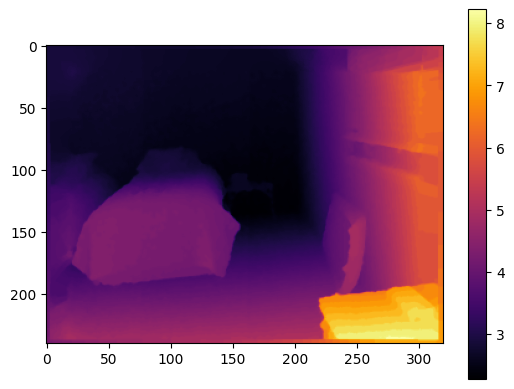

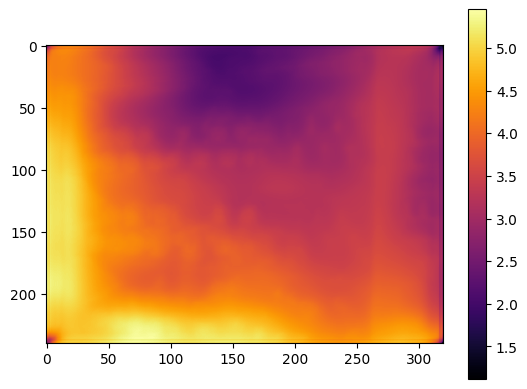

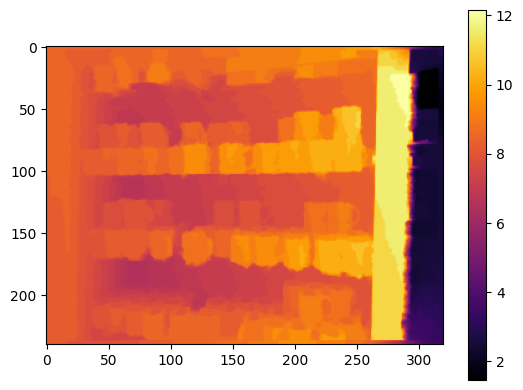

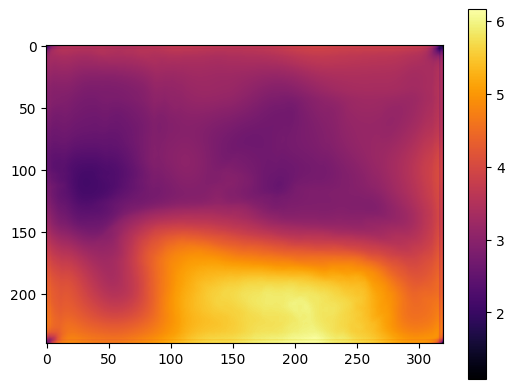

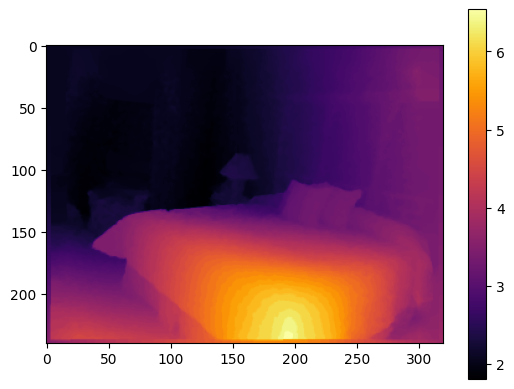

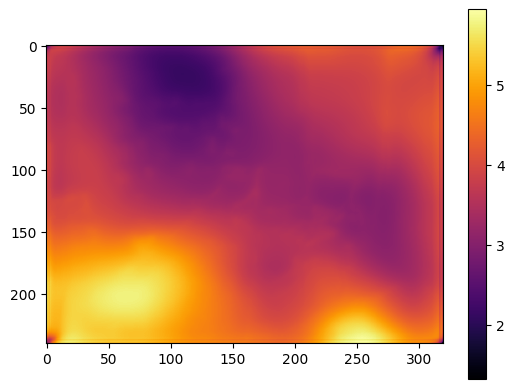

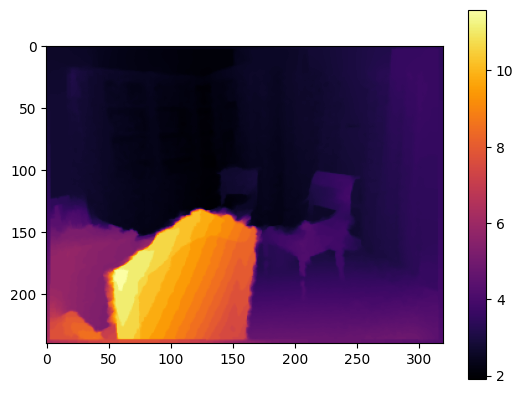

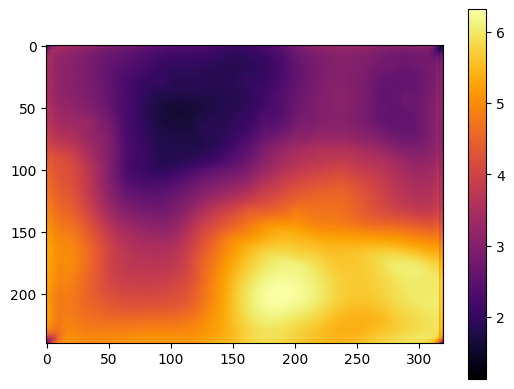

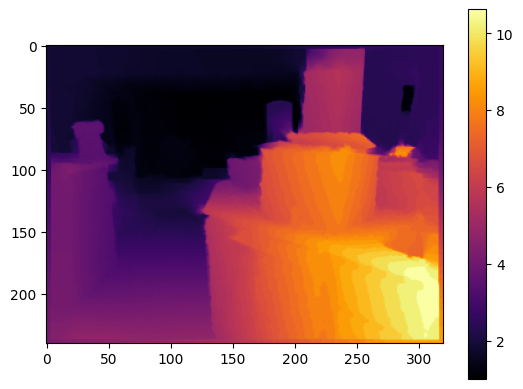

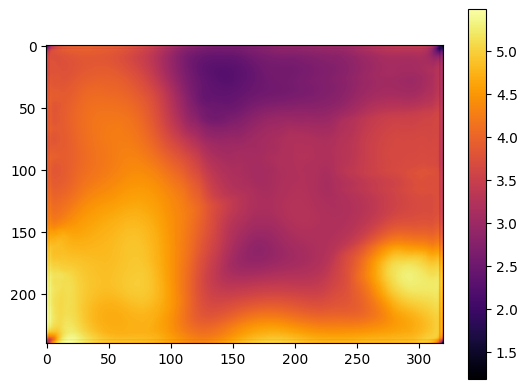

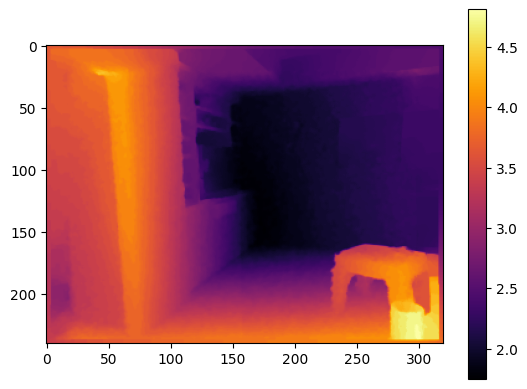

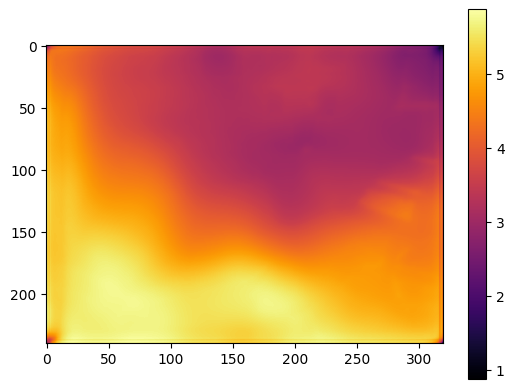

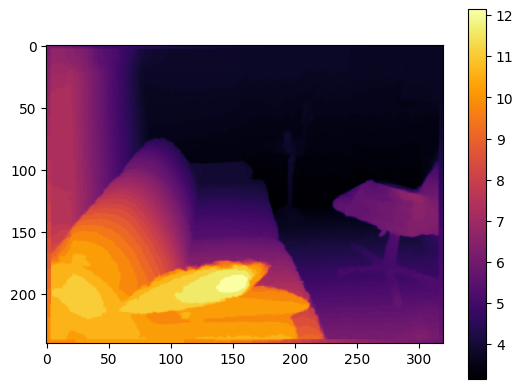

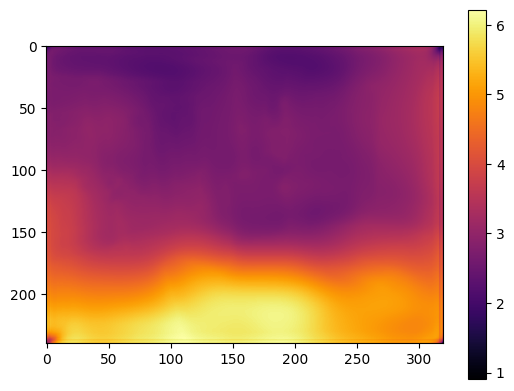

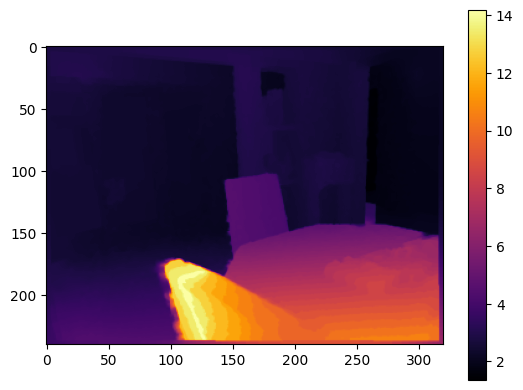

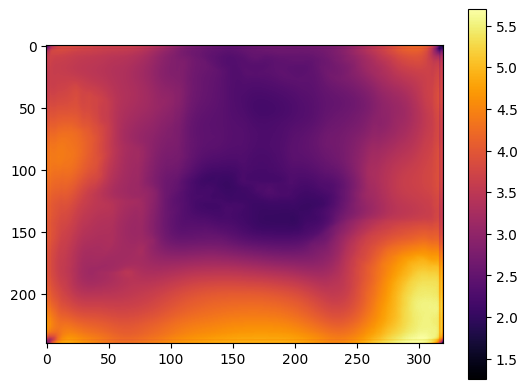

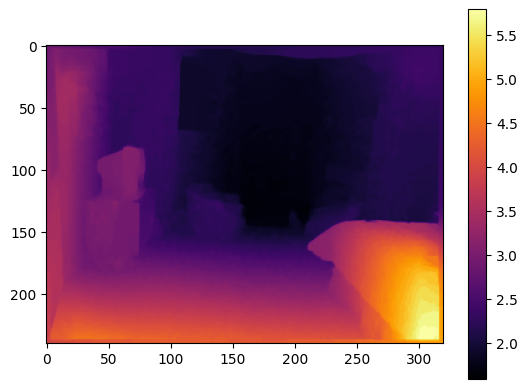

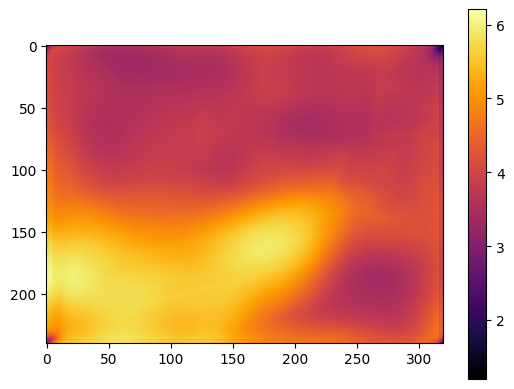

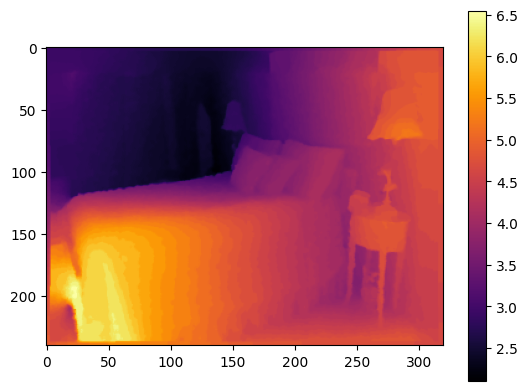

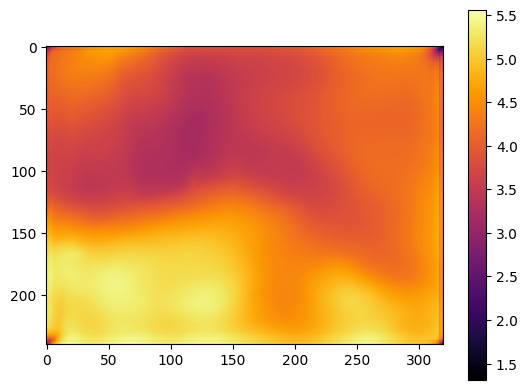

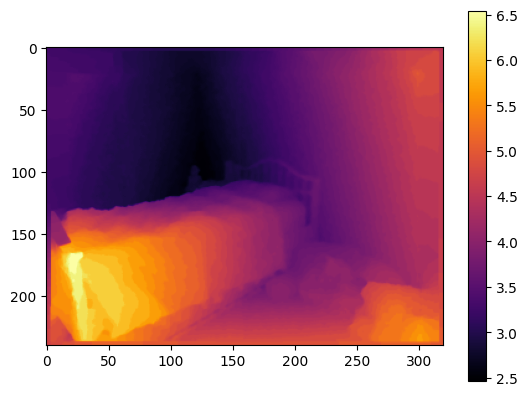

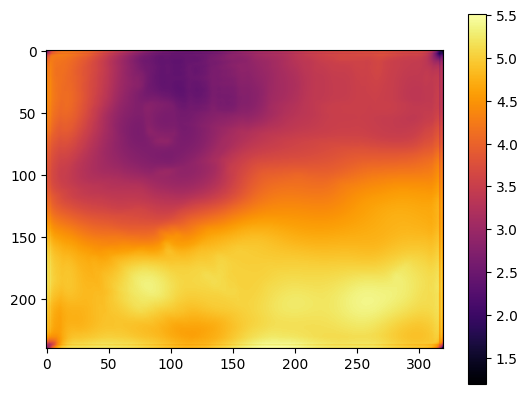

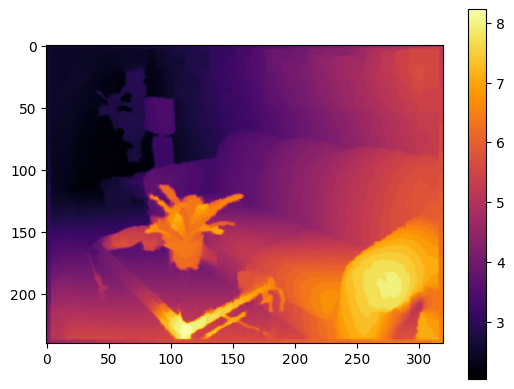

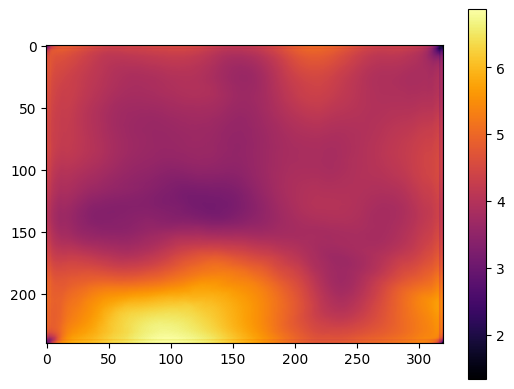

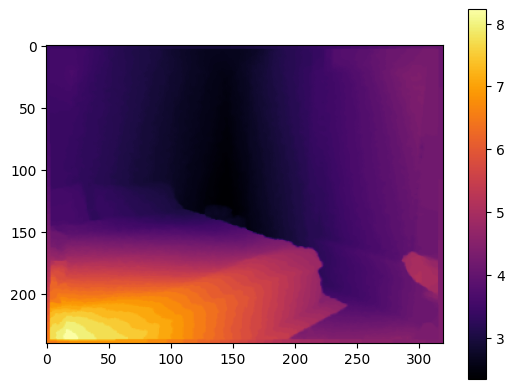

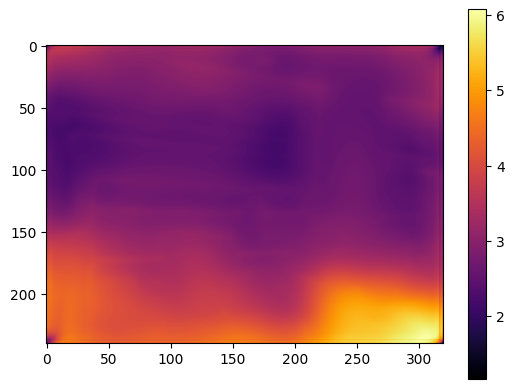

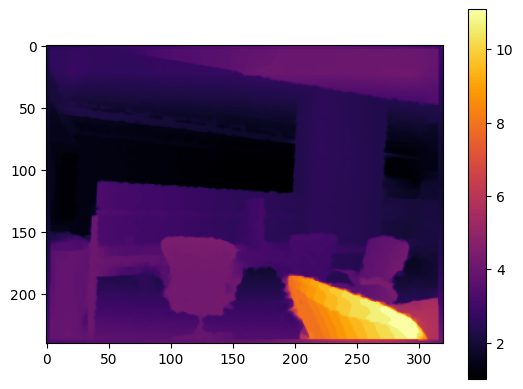

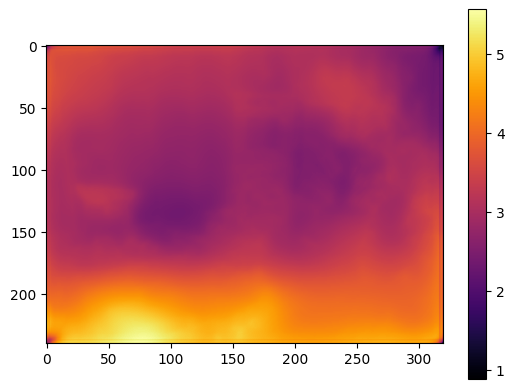

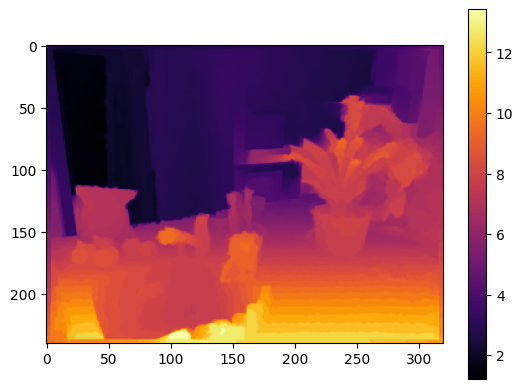

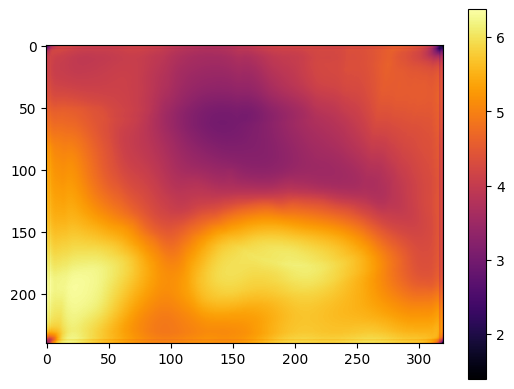

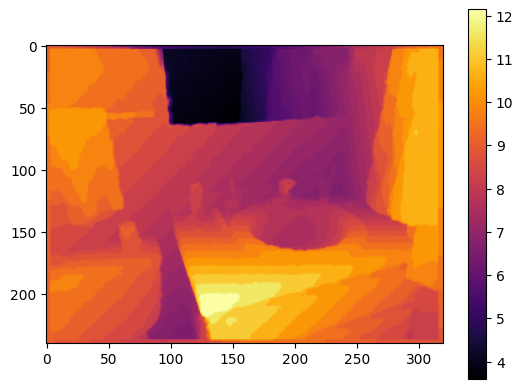

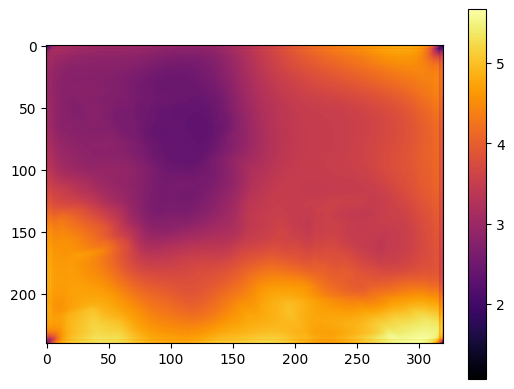

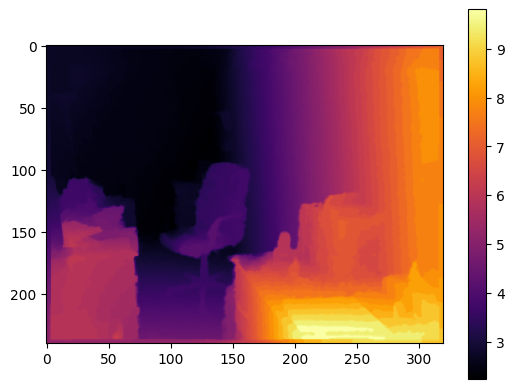

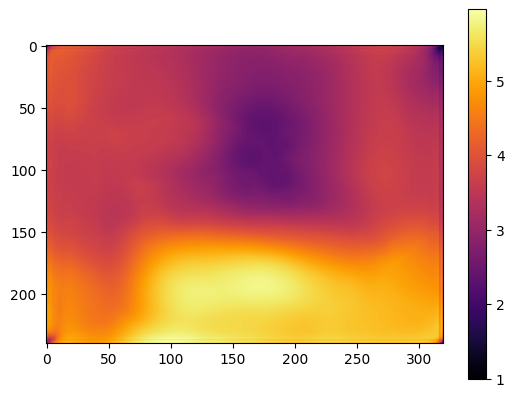

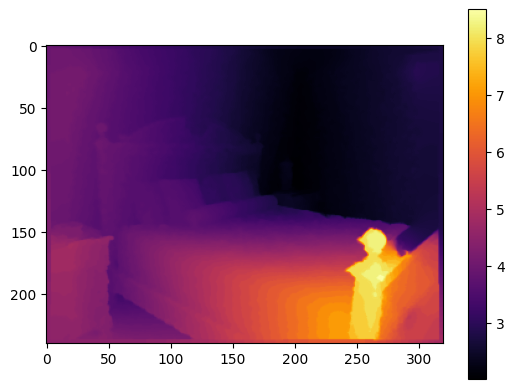

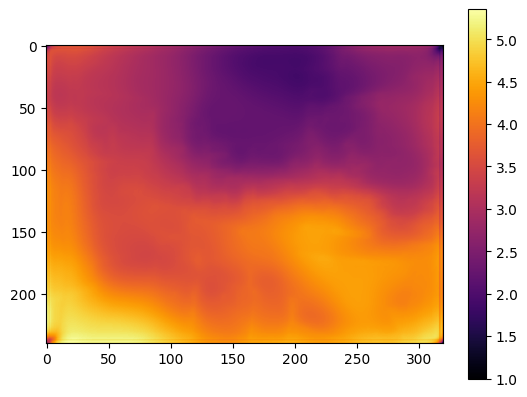

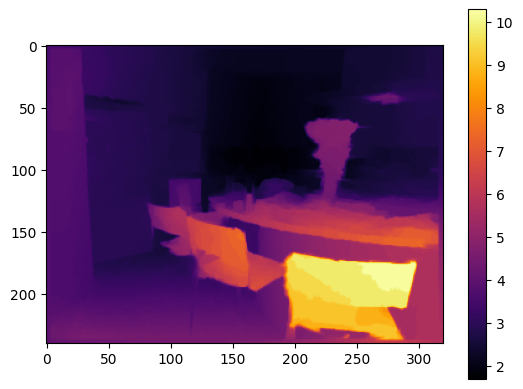

KeyboardInterrupt: 

In [ ]:
for images, gt_maps in valDataLoader:
  images = images.to(device)
  gt_maps = gt_maps.to(device)

  pred_maps = model(images)

  plt.figure("pred_map")
  plt.imshow(pred_maps[0].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(gt_maps[0].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[1].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(gt_maps[1].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[2].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(gt_maps[2].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("pred_map")
  plt.imshow(pred_maps[3].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()

  plt.figure("gt_map")
  plt.imshow(gt_maps[3].permute(1,2,0).cpu().detach(), cmap='inferno'), plt.colorbar()
  plt.show()
